In [32]:
import numpy as np
import cv2 as cv
import skimage.io
import matplotlib.pyplot as plt
import os
import keras
from scipy import ndimage
from sklearn import preprocessing

In [2]:
from scipy.ndimage import zoom
def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.ones_like(img)*255
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, cval=255, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, cval=255)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [3]:
data_base_path = os.path.join(os.pardir, 'project')
data_folder = 'data/frame'

# Load image
data_path = os.path.join(data_base_path, data_folder)

frames = []

for i in range(42):
    frame = skimage.io.imread(os.path.join(data_path, 'frame'+str(i)+'.jpeg'))
    frames.append(frame)

In [4]:
data_path = os.path.join(data_base_path, 'data')

operator = skimage.io.imread(os.path.join(data_path, 'original_operators.png'))

In [5]:
plus = operator[16:316, 0:300, :]
egal = operator[:, 350:650,:]
minus = operator[:, 700:1000,:]
div = operator[:, 1080:1380,:]
times = operator[:, 1450:1750,:]

operators = [plus, minus, div, times, egal]

In [93]:
def random_transformations(img):
    img = ndimage.rotate(img, np.random.randint(360), reshape=False, mode='constant', cval=255, order=5, prefilter=False)
    T = np.concatenate([np.identity(2), np.random.uniform(low=-2, high=2, size=(2,1))], axis=1)
    img = cv.warpAffine(img, T, img.shape, borderValue=255)

    noise = np.random.normal(0, 9, img.shape)
    g_blur = cv.GaussianBlur(img, (5, 5), 1, 1)
    g_blur = g_blur + noise
    zoomed = clipped_zoom(g_blur, np.random.uniform(0.7, 1.1))
    clipped = zoomed.clip(0, 255)

    return clipped

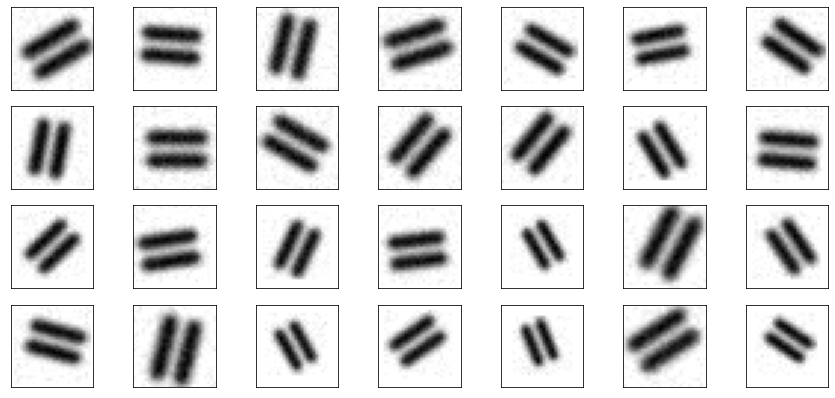

In [100]:
times_pos = (80, 145)
plus_pos = (273, 184) 
div_pos = (192, 357)
equal_pos = (92, 282)
size = 28

pos = equal_pos
img = egal


dim = (size, size)
# resize image
resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
 
img = resized[:,:,0]

g_blur = random_transformations(img)

fig, ax = plt.subplots(4, 7, figsize=(15, 7))

for axis in ax.flatten():
    axis.imshow(random_transformations(img), cmap='gray')
    axis.set_xticks([]), axis.set_yticks([])

'''
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(g_blur, cmap='gray')
ax[1].set_title('Gaussian blur + uniform noise')
'''
plt.show()

In [101]:
dataset = []

for img in [plus, minus, div, times, egal]:
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    resized = cv.resize(gray, (size, size), interpolation = cv.INTER_AREA)

    for i in range(10_000):
        out = random_transformations(resized)
        out /= 255
        out = 1-out
        
        dataset.append(out)
        
dataset = np.array(dataset)
print(dataset.shape)

(50000,)


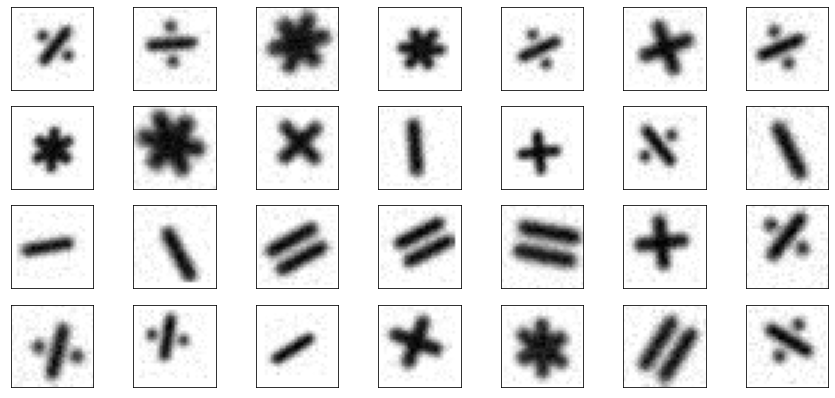

In [102]:
fig, ax = plt.subplots(4, 7, figsize=(15, 7))
for axis in ax.flatten():
    axis.imshow(1-dataset[int(np.random.uniform(0, len(dataset)))], cmap='gray')
    axis.set_xticks([]), axis.set_yticks([])
plt.show()